<a href="https://colab.research.google.com/github/brianbaert/MscThesis/blob/main/MscThesis_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
!python --version

Python 3.10.14


In [2]:
#!pip install avalanche_lib[all]
#!pip install gwpy
#!pip install nds2
!pip show avalanche-lib
!pip show gwpy

Name: avalanche-lib
Version: 0.5.0
Summary: Avalanche: a Comprehensive Framework for Continual Learning Research
Home-page: https://github.com/ContinualAI/avalanche
Author: ContinualAI
Author-email: contact@continualai.org
License: 
Location: c:\programdata\anaconda3\envs\mscthesis\lib\site-packages
Requires: dill, gdown, gputil, matplotlib, numpy, packaging, psutil, pytorchcv, qpsolvers, scikit-learn, tensorboard, torch, torchmetrics, torchvision, tqdm, typing-extensions, wandb
Required-by: 
Name: gwpy
Version: 3.0.8
Summary: A python package for gravitational-wave astrophysics
Home-page: 
Author: 
Author-email: Duncan Macleod <duncan.macleod@ligo.org>
License: GPL-3.0-or-later
Location: c:\programdata\anaconda3\envs\mscthesis\lib\site-packages
Requires: astropy, dateparser, dqsegdb2, gwdatafind, gwosc, h5py, ligo-segments, ligotimegps, matplotlib, numpy, python-dateutil, requests, scipy, tqdm
Required-by: 


In [2]:
 #%cd /content/drive/MyDrive/MscThesis
%pwd

'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis'

In [77]:
import numpy as np
import os
import pandas as pd
import time

from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin
from avalanche.training.supervised import VAETraining
from avalanche.benchmarks import nc_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix,disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [78]:
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers)
print(number_of_workers)

8


# DL Baseline

In [79]:
#train_dir = '/content/drive/MyDrive/MscThesis/GravitySpy/train/train'
train_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\train\\train'
#val_dir = '/content/drive/MyDrive/MscThesis/GravitySpy/validation/validation'
val_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\validation\\validation'
#test_dir = '/content/drive/MyDrive/MscThesis/GravitySpy/test/test'
test_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\test\\test'
#metadata_o3b = '/content/drive/MyDrive/MscThesis/data_o3b_high_confidence.csv'
#metadata_o3a = '/content/drive/MyDrive/MscThesis/data_o3a_high_confidence.csv'
#metadata_o1L1 = '/content/drive/MyDrive/MscThesis/GravitySpy/L1_O1.csv'
#metadata_o2L1 = '/content/drive/MyDrive/MscThesis/GravitySpy/L1_O2.csv'

In [80]:
#meta_train_v1 = pd.read_csv('/content/drive/MyDrive/MscThesis/GravitySpy/trainingset_v1d1_metadata.csv')
meta_train_v1 = pd.read_csv('C:\\Users\\Brian.Baert\\GravitySpy\\trainingset_v1d1_metadata.csv')
print(meta_train_v1[meta_train_v1['sample_type']=='train']['label'].value_counts())
classes = meta_train_v1['label'].unique()
classes

label
Blip                   1274
Koi_Fish                498
Low_Frequency_Burst     437
Light_Modulation        361
Extremely_Loud          316
Low_Frequency_Lines     315
Power_Line              314
Scattered_Light         308
Violin_Mode             284
Scratchy                237
1080Lines               229
Whistle                 208
Helix                   195
Repeating_Blips         185
No_Glitch               107
Tomte                    73
1400Ripples              59
None_of_the_Above        57
Air_Compressor           41
Chirp                    41
Wandering_Line           29
Paired_Doves             19
Name: count, dtype: int64


array(['Whistle', '1080Lines', 'Blip', 'Violin_Mode',
       'Scattered_Light', 'Power_Line', 'Light_Modulation',
       'Koi_Fish', 'None_of_the_Above', 'Scratchy', 'Tomte',
       'Chirp', 'Wandering_Line', 'Extremely_Loud',
       'Repeating_Blips', 'No_Glitch', 'Low_Frequency_Lines',
       'Paired_Doves', 'Low_Frequency_Burst', 'Helix',
       'Air_Compressor', '1400Ripples'], dtype=object)

In [81]:
classes = my_utils.get_classes_from_dir(train_dir)

In [82]:
class_to_indx = {c: i for i, c in enumerate(classes)}

In [83]:
transformGray = transforms.Compose([
     transforms.Resize((140,170)),
     transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
    ])

transformRGB = transforms.Compose([
     transforms.Resize((140,170)),
     transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

transformAV = transforms.Compose([
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
    ])

transformAV_AR1 = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
    ])

In [84]:
train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=number_of_workers)
test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [75]:
train_set = my_dataloaders.GravitySpy_0_5_dataset(root=train_dir, cls=classes, transform=transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_0_5_dataset(root=val_dir, cls=classes, transform=transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)
test_set = my_dataloaders.GravitySpy_0_5_dataset(root=test_dir, cls=classes, transform=transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [85]:
print("The training loader contains {} instances, the val loader contains {} instances and the test loader contains {} instances".format(len(train_loader), len(val_loader), len(test_loader)))

The training loader contains 175 instances, the val loader contains 75 instances and the test loader contains 1180 instances


In [86]:
class_counts = train_set.count_class_instances()
class_weights = []
for class_name, count in class_counts.items():
  print(f"{class_name}: {count} instances")
  class_weights.append(1.0/(count/len(train_set)))

print(class_weights)

0: 229 instances
1: 59 instances
2: 41 instances
3: 1274 instances
4: 41 instances
5: 316 instances
6: 195 instances
7: 498 instances
8: 361 instances
9: 437 instances
10: 315 instances
11: 57 instances
12: 107 instances
13: 19 instances
14: 314 instances
15: 185 instances
16: 308 instances
17: 237 instances
18: 73 instances
19: 284 instances
20: 29 instances
21: 208 instances
[24.397379912663755, 94.6949152542373, 136.26829268292684, 4.385400313971743, 136.26829268292684, 17.680379746835442, 28.651282051282053, 11.218875502008032, 15.476454293628809, 12.784897025171624, 17.736507936507937, 98.01754385964912, 52.21495327102804, 294.0526315789474, 17.792993630573246, 30.2, 18.13961038961039, 23.57383966244726, 76.53424657534246, 19.672535211267604, 192.6551724137931, 26.860576923076923]


In [14]:
# Create Neural Network architecture for finetuning
myNet = my_architectures.BaselineGrayscaleNet_resnet18()
myNet.to(device)
print(myNet)

C:\ProgramData\anaconda3\envs\MscThesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\MscThesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


BaselineGrayscaleNet_resnet18(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [79]:
# Pytorch Training loop
epoch_test_loss = 0
epoch_test_acc = 0
epoch_test_correct = 0
epoch_test_total = 0
best_vloss = 1_000_000.
avg_loss = 0
last_loss = 0
timestamp = my_utils.get_timestamp()

# Define the loss function and optimizer
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)
optimizer = Adam(myNet.parameters(), lr=0.001, weight_decay=1e-3) #LR from the study of Tiago Fernandes

# Number of epochs to train for
num_epochs = 10
epoch_number = 0

start = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
  total_correct = 0
  total_samples = 0
  print('EPOCH {}: '.format(epoch_number + 1))
  train_loss = 0.0
  myNet.train(True)

  ## TRAINING ONE EPOCH
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = myNet(inputs)
    # compute loss and gradient
    loss = criterion(outputs, labels)
    #add part of regularization
    l2_reg = torch.tensor(0.0)
    for param in myNet.parameters():
      if param.requires_grad: #exclude frozen layers
        l2_reg += torch.norm(param, p=2)
    loss += 1e-5 * l2_reg
    #end part of regularization
    loss.backward()
    # adjust learning weights
    optimizer.step()

    # print statistics
    _, predicted = torch.max(outputs, 1)
    train_loss += loss.item()
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    if i % 16 == 15:
      last_loss = train_loss / 16
      print('  batch {} loss: {}, acc: {}'.format(i+1, last_loss, 100*total_correct/total_samples))
      tb_x = epoch * len(train_loader) + i + 1
      train_loss=0.
    avg_loss = last_loss

  ## VALIDATION
  running_vloss = 0.0
  myNet.eval()

  # disable gradient computation for validation
  with torch.no_grad():
    for i, vdata in enumerate(val_loader):
      vinputs, vlabels = vdata
      vinputs, vlabels = vinputs.to(device), vlabels.to(device)
      voutputs = myNet(vinputs)
      vloss = criterion(voutputs, vlabels)
      running_vloss += vloss
  avg_vloss = running_vloss / (i+1)
  print('LOSS train {:.4f} valid {:.4f} after {} seconds'.format(avg_loss, avg_vloss, time.time()-start))

  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(myNet.state_dict(), model_path)

  #my_utils.checkpoint(myNet, f"epoch-{epoch}.pth")
  epoch_number += 1

end = time.time()
print('Training finished after ', end-start, ' seconds')

EPOCH 1: 
  batch 16 loss: 3.8687445670366287, acc: 31.640625
  batch 32 loss: 3.0974351167678833, acc: 45.01953125
  batch 48 loss: 2.8755159080028534, acc: 52.5390625
  batch 64 loss: 2.9014636427164078, acc: 56.15234375
  batch 80 loss: 3.0529196858406067, acc: 58.1640625
  batch 96 loss: 2.8696737587451935, acc: 59.016927083333336
  batch 112 loss: 2.994697779417038, acc: 60.072544642857146
  batch 128 loss: 2.7760147750377655, acc: 61.4990234375
  batch 144 loss: 2.6057771518826485, acc: 62.282986111111114
  batch 160 loss: 2.705772504210472, acc: 63.30078125
LOSS train 2.7058 valid 2.8425 after 487.2898406982422 seconds
EPOCH 2: 
  batch 16 loss: 3.000696137547493, acc: 76.953125
  batch 32 loss: 2.6400260105729103, acc: 76.46484375
  batch 48 loss: 2.623463496565819, acc: 77.5390625
  batch 64 loss: 2.604837477207184, acc: 77.63671875
  batch 80 loss: 2.427819103002548, acc: 77.6171875
  batch 96 loss: 2.647399514913559, acc: 76.85546875
  batch 112 loss: 2.8112524896860123, acc

In [80]:
#save model
#torch.save(myNet.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_0_5.pth')
torch.save(myNet.state_dict(), 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_0_5.pth')
print("Saved Pytorch Model state to thesis_baseline.pth")

Saved Pytorch Model state to thesis_baseline.pth


In [22]:
#myNet.load_state_dict(torch.load('/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_1_0.pth'))
myNet.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_1_0.pth'))

<All keys matched successfully>

In [23]:
my_utils.n_test_predictions(myNet, test_loader, classes, 20)

Predicted: "Light_Modulation", Actual: "Light_Modulation"
Predicted: "Whistle", Actual: "Whistle"
Predicted: "Power_Line", Actual: "Power_Line"
Predicted: "1400Ripples", Actual: "1400Ripples"
Predicted: "Violin_Mode", Actual: "Violin_Mode"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Whistle", Actual: "Whistle"
Predicted: "Power_Line", Actual: "Power_Line"
Predicted: "1080Lines", Actual: "1080Lines"
Predicted: "Light_Modulation", Actual: "Light_Modulation"
Predicted: "1080Lines", Actual: "1080Lines"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Light_Modulation", Actual: "Light_Modulation"
Predicted: "Blip", Actual: "Blip"
Predicted: "None_of_the_Above", Actual: "Low_Frequency_Burst"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Repeating_Blips", Actual: "Repeating_Blips"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Blip", Actual: "Blip"
Predicted: "1080Lines", Actual: "1080Lines"
n_test_predictions: 980.4608

In [24]:
y_pred_list, y_true_list = my_utils.get_predictions(myNet, test_loader)

get_predictions: 52113.90471458435 ms


In [25]:
# Generate confusion matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

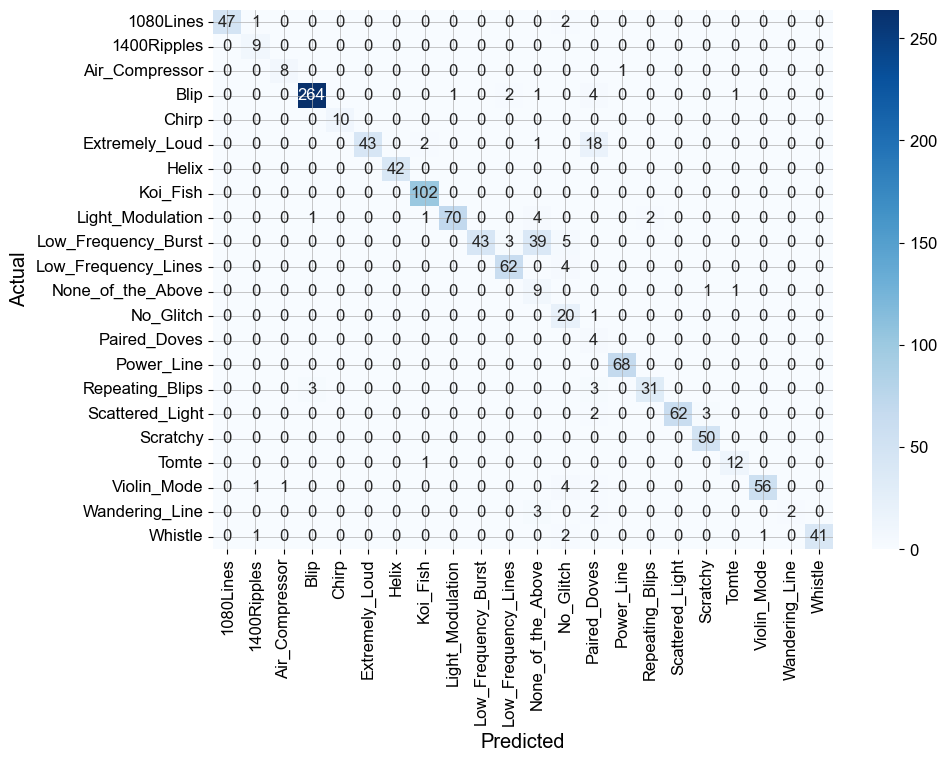

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('confusion_matrix_baseline_1_0.png')
plt.close()

In [29]:
print(f"F1 Score for each class: {f1}")
print(f"The average F1 score is: {f1_score(y_true_list, y_pred_list, average='weighted')}")

F1 Score for each class: [0.96907216 0.85714286 0.88888889 0.97597043 1.
 0.80373832 1.         0.98076923 0.93959732 0.64661654
 0.93233083 0.26470588 0.68965517 0.2        0.99270073
 0.88571429 0.96124031 0.96153846 0.88888889 0.92561983
 0.44444444 0.95348837]
The average F1 score is: 0.9109037169739465


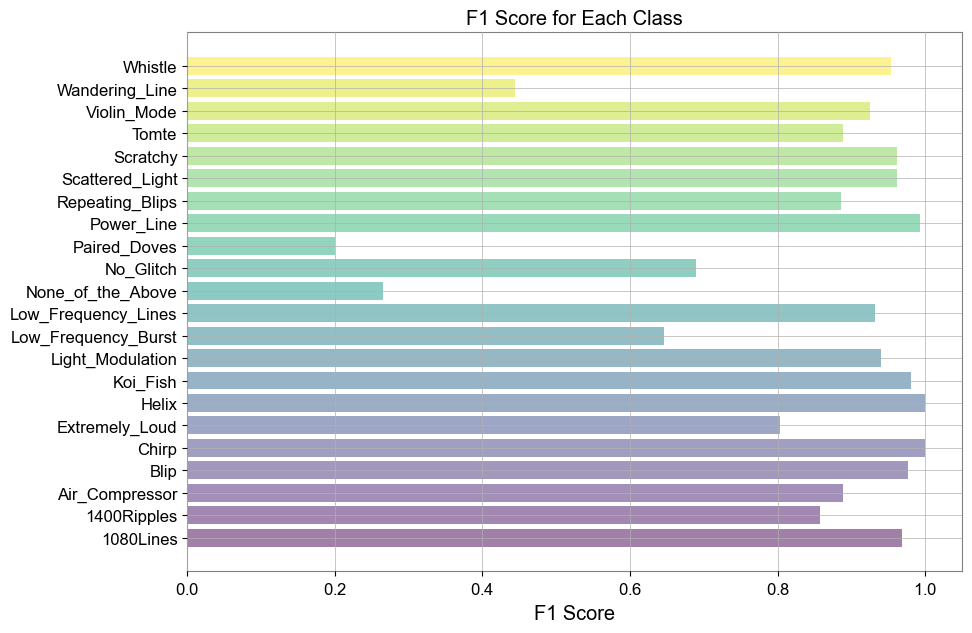

In [30]:
# Create a horizontal bar plot for F1 scores with different colors
plt.figure(figsize=(10,7))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.barh(np.arange(len(classes)), f1, color=colors, align='center', alpha=0.5)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('F1 Score')
plt.title('F1 Score for Each Class')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('f1_scores_baseline_1_0.png')
plt.close()

# CL Base model

In [87]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SlimResNet18(nclasses=22)
model.to(device)
interactive_logger = InteractiveLogger()

In [101]:
#train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=transformAV)
#val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=transformAV)
#test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=transformAV)

train_set = my_dataloaders.GravitySpy_0_5_dataset(root=train_dir, cls=classes, transform=transformAV)
val_set = my_dataloaders.GravitySpy_0_5_dataset(root=val_dir, cls=classes, transform=transformAV)
test_set = my_dataloaders.GravitySpy_0_5_dataset(root=test_dir, cls=classes, transform=transformAV)

#train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=transformAV_AR1)
#val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=transformAV_AR1)
#test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=transformAV_AR1)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)


train_set_av.targets = train_set.labels
test_set_av.targets = test_set.labels
val_set_av.targets = val_set.labels

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [102]:
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=11,
    shuffle=True,
    seed=123,
    task_labels=False,
)

In [103]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=bm.n_classes, save_image=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

cl_strategy = Naive(
#cl_strategy = LwF(
#cl_strategy = ICaRL(
#cl_strategy= EWC(
#cl_strategy = AR1(
#cl_strategy = VAETraining(
    #model, optimizer, criterion, ewc_lambda=5.5, train_epochs=10, mode='online', decay_factor=0.05, keep_importance_data=True, train_mb_size=32, eval_mb_size=16, device=device
    model, optimizer, criterion, train_mb_size=32, train_epochs=4, eval_mb_size=16, device=device, plugins=[eval_plugin, ReplayPlugin(mem_size=1000), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

C:\ProgramData\anaconda3\envs\MscThesis\lib\site-packages\avalanche\training\templates\base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [104]:
for experience in bm.train_stream:
  print(experience.classes_in_this_experience)

[2, 14]
[4, 15]
[0, 3]
[9, 12]
[11, 13]
[17, 21]
[18, 20]
[1, 10]
[16, 6]
[8, 19]
[5, 7]


In [ ]:
print('Starting experiment...')
results = []
for experience in bm.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    cl_strategy.train(experience, num_workers=0)
    print('Training completed')

Starting experiment...
Start of experience:  0
Current Classes:  [2, 14]
-- >> Start of training phase << --
-- >> Start of training phase << --
100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0006
	Loss_MB/train_phase/train_stream/Task000 = 3.0409
	Time_Epoch/train_phase/train_stream/Task000 = 7.5001
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7859
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0006
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7859
100%|██████████| 12/12 [00:04<00:00,  2.42it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7896
	Loss_MB/train_phase/train_stream/Task000 = 2.8536
	Time_Epoch/train_phase/train_stream/Task000 = 4.9652
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9972
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|█████

In [94]:
#save model
torch.save(model.state_dict(), 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_Naive_CL_0_5.pth')
#torch.save(model.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_generative_CL_1_0.pth')
print("Saved Pytorch Model state to thesis_EWC_CL_1_0.pth")

Saved Pytorch Model state to thesis_EWC_CL_1_0.pth


In [95]:
model = SlimResNet18(nclasses=22)
model.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_Naive_CL_0_5.pth'))
#model.load_state_dict(torch.load('/content/drive/MyDrive/MscThesis/thesis_generative_CL_1_0.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=

In [93]:
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Extremely_Loud", Actual: "Light_Modulation"
Predicted: "1400Ripples", Actual: "1400Ripples"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Paired_Doves", Actual: "Blip"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Wandering_Line", Actual: "1080Lines"
Predicted: "Wandering_Line", Actual: "1080Lines"
Predicted: "Scattered_Light", Actual: "Scattered_Light"
Predicted: "Violin_Mode", Actual: "Violin_Mode"
Predicted: "Power_Line", Actual: "Power_Line"
Predicted: "Low_Frequency_Burst", Actual: "Low_Frequency_Burst"
Predicted: "Koi_Fish", Actual: "Koi_Fish"
Predicted: "Whistle", Actual: "Low_Frequency_Burst"
Predicted: "Wandering_Line", Actual: "1080Lines"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Extremely_Loud", Actual: "Extremely_Loud"
Predicted: "No_Glitch", Actual: "No_Glitch"
Predicted: "Paired_Doves", Actual: "Blip"
Predicted: "1080Lines", Actual: "1080Lines"
n_t

In [96]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 23735.92233657837 ms


In [97]:
# Generate confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

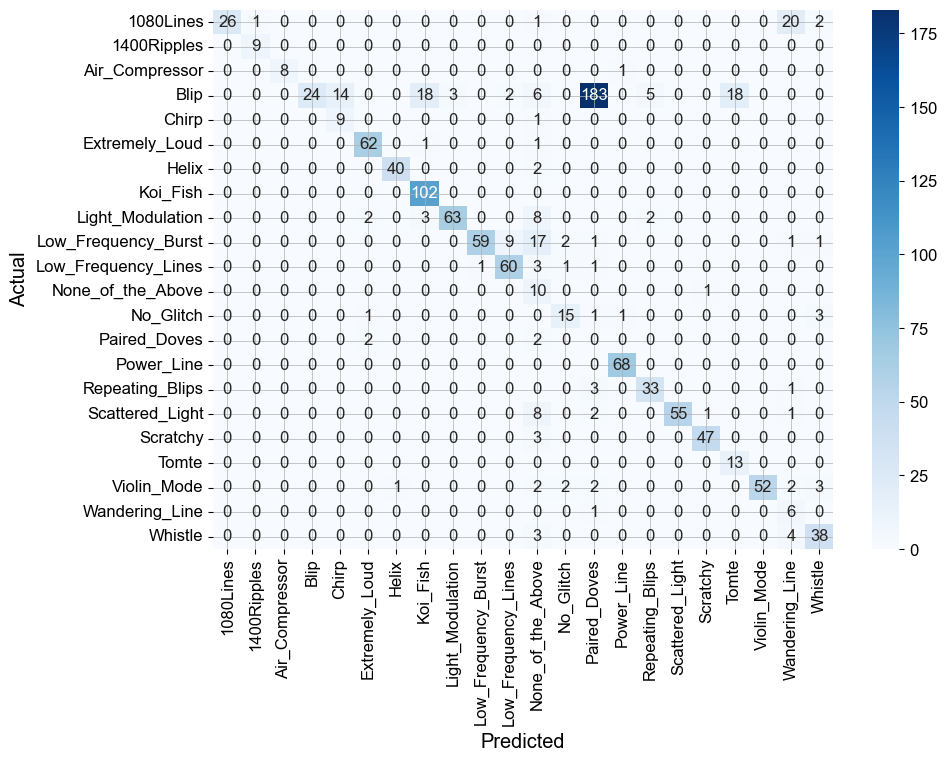

In [99]:
plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('f1_scores_Naive_1_0.png')
plt.close()

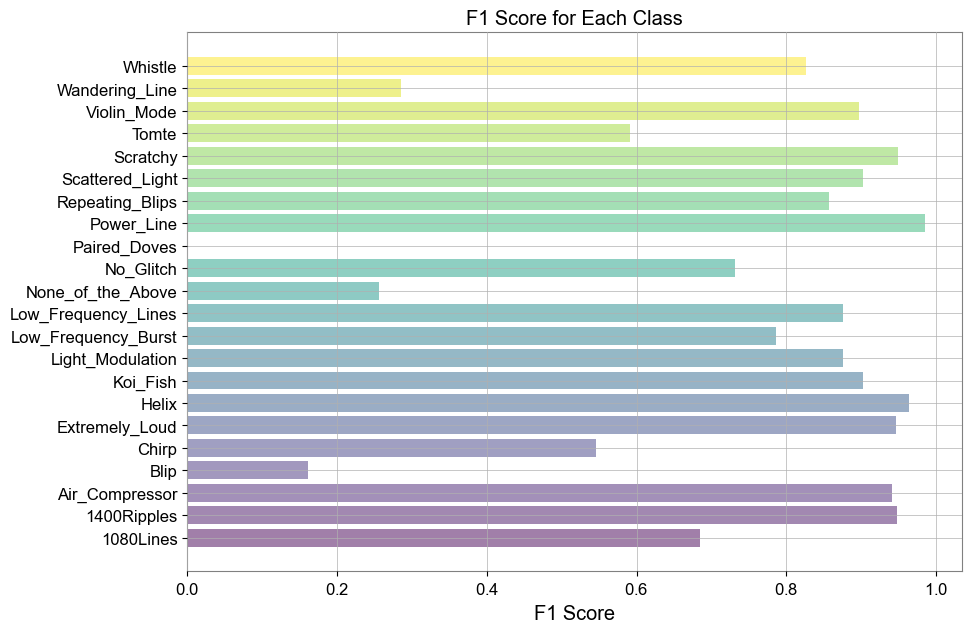

In [100]:
# Create a horizontal bar plot for F1 scores with different colors
plt.figure(figsize=(10,7))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.barh(np.arange(len(classes)), f1, color=colors, align='center', alpha=0.5)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('F1 Score')
plt.title('F1 Score for Each Class')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('f1_scores_Naive_1_0.png')
plt.close()